# Decompilation using Transformer models with attention

#### Setup Colab GPU environment
To reproduce the following steps, it is recommended to run this notebook in a Google Colab environment connected to a GPU. Using only a CPU will result in a huge time for training task. In Colab, you can check if you are connected to a working GPU with the following cell:

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 24 13:54:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We also need to install tensorflow 2.5.0.

In [ ]:
!pip install tensorflow==2.5.0

We recommend running this notebook in colab/jupyter instead of vscode because some cells contain thousands of lines and vscode do not truncate these lines.

# Intuition
In this notebook, we want to demonstrate **if Deep Learning and especially Transformer models can be applied to decompilation tasks**. Transformer models are used for common NLP tasks and is the state of the art in this field. We think that decompilation can be seen as a translation task, where we want to translate a low level programming language (PL) to a higher level programming language. In the following examples, we'll using as low level PL the Assembly MIPS and as high level PL the C language.

## Data loading
The first step is to find data in order to feed our future Deep Learning model.
Hopefuly, **previous researchers at Facebook published a dataset contaning 10k pairs of ASM mips/C code**. The samples of code are examples using mathematical functions of the `math.h` C library. This dataset is given in the repo in the `data/` folder. Two folders are in data/: asm_src containing 10k ASM mips files, and c_src contaning 10k C files. As you may suppose, each ith file correspond to the associated assembly/C equivalent.

After moving the data/ folder in the root of this Colab notebook, run the following cell to load the datset.
A `RawCodeTokenizer` object is created to manage all the preprocessing stuff (loading, dataprep, tokenization).

We also have to copy the deepiler module at the root of the Colab file explorer in order to access the files

In [3]:
from deepiler.preprocessing import RawCodeTokenizer

tokenizer = RawCodeTokenizer()

Run the `load_dataset()` method to fetch the data containing in files as a generator containing pairs of code (ASM, C).
It is also here that we specify the ratio we want to separate our dataset in train/test datasets. Here, we chose 90% as ratio.

In [4]:
c_path = "./data/c_src"
asm_path = "./data/asm_src"

# Means 90% of files are in training dataset and 
# remaining 10% are considered testing test
train_eval_ratio = .9
nb_files = 10_000

train_dataset = tokenizer.load_dataset(asm_path, c_path, is_train=True, \
        nb_files=nb_files, train_eval_ratio=train_eval_ratio)

Let's see what's inside the dataset:

In [5]:
asm, c = next(train_dataset)
asm

'\t.text\n\t.abicalls\n\t.option\tpic0\n\t.section\t.mdebug.abi32,"",@progbits\n\t.nan\tlegacy\n\t.file\t"rd_0.cc"\n\t.text\n\t.globl\tmain                    # -- Begin function main\n\t.p2align\t2\n\t.type\tmain,@function\n\t.set\tnomicromips\n\t.set\tnomips16\n\t.ent\tmain\nmain:                                   # @main\n\t.cfi_startproc\n\t.frame\t$fp,80,$ra\n\t.mask \t0xc0000000,-12\n\t.fmask\t0x00300000,-8\n\t.set\tnoreorder\n\t.set\tnomacro\n\t.set\tnoat\n# %bb.0:\n\taddiu\t$sp, $sp, -80\n\t.cfi_def_cfa_offset 80\n\tsdc1\t$f20, 72($sp)           # 8-byte Folded Spill\n\tsw\t$ra, 68($sp)            # 4-byte Folded Spill\n\tsw\t$fp, 64($sp)            # 4-byte Folded Spill\n\t.cfi_offset 52, -8\n\t.cfi_offset 53, -4\n\t.cfi_offset 31, -12\n\t.cfi_offset 30, -16\n\tmove\t$fp, $sp\n\t.cfi_def_cfa_register 30\n\tsw\t$zero, 60($fp)\n\tldc1\t$f12, 24($fp)\n\tjal\tatan2\n\tldc1\t$f14, 16($fp)\n\tsdc1\t$f0, 40($fp)\n\tldc1\t$f12, 40($fp)\n\tjal\tfmax\n\tldc1\t$f14, 48($fp)\n\tsdc1\t$f0,

In [6]:
c

'#include <stdio.h>\n#include <math.h>\n\nint main(){\ndouble a;\ndouble b;\ndouble c;\ndouble d;\ndouble e;\nb=atan2(d,e);\nd=fmax(b,a);\ne=exp(e);\na=(sqrt(b))+(cos(b));\nwhile(islessgreater(b,b)){\nb=pow(e,b);\nb=fdim(c,d);\nb=(acos(b))*(atan2(c,a));\nc=(ceil(e))*(pow(b,d));\nb=atan2(a,e);\n}\nif(islessgreater(a,d)){\nd=(exp(c))*(fmax(b,a));\ne=sin(b);\na=(fmin(b,b))/(floor(a));\nc=pow(b,e);\nd=(log10(a))+(atan(a));\n}\nelse{\nd=pow(a,b);\na=(atan2(b,c))/(ceil(d));\n}\n}'

No surprise here, asm and C code as expected, note that the \n can be printed as line return using the print() method.

## Preprocessing
Before feeding our model with data, we have to preprocess them in order clean the text. For example, in our datasets, the C and ASM codes are glued. If no space separe the ascii characters, then the tokenizer will not recognize that some tokens are glued and it will only consider few huge tokens (ex: one line will become one token). **So we want to add spaces between C and ASM tokens.** That's what does the `preprocess_dataset()` method.

**Current C:** `
e=exp(e); 
a=(sqrt(b))+(cos(b));`

**Expected C:** `
e = exp ( e ) ; 
a = ( sqrt ( b ) ) + ( cos ( b ) ) ;`

**Current ASM:** `
ldc1	$f14, 16($fp)`

**Expected ASM:** `
ldc1	$ f14 , 16 ( $fp )`


In [7]:
dataset = tokenizer.preprocess_dataset(train_dataset)

In [8]:
asm, c = next(dataset)
asm

'\t.text\n\t.abicalls\n\t.option\tpic0\n\t.section\t.mdebug.abi32 , "" , @progbits\n\t.nan\tlegacy\n\t.file\t"rd_1.cc"\n\t.text\n\t.globl\tmain                    # -- Begin function main\n\t.p2align\t2\n\t.type\tmain , @function\n\t.set\tnomicromips\n\t.set\tnomips16\n\t.ent\tmain\nmain:                                   # @main\n\t.cfi_startproc\n\t.frame\t$fp , 88 , $ra\n\t.mask \t0xc0000000 , -12\n\t.fmask\t0x00300000 , -8\n\t.set\tnoreorder\n\t.set\tnomacro\n\t.set\tnoat\n# %bb.0:\n\taddiu\t$sp ,  $sp ,  -88\n\t.cfi_def_cfa_offset 88\n\tsdc1\t$f20 ,  80 ( $sp )            # 8-byte Folded Spill\n\tsw\t$ra ,  76 ( $sp )             # 4-byte Folded Spill\n\tsw\t$fp ,  72 ( $sp )             # 4-byte Folded Spill\n\t.cfi_offset 52 ,  -8\n\t.cfi_offset 53 ,  -4\n\t.cfi_offset 31 ,  -12\n\t.cfi_offset 30 ,  -16\n\tmove\t$fp ,  $sp\n\t.cfi_def_cfa_register 30\n\tsw\t$zero ,  68 ( $fp ) \n\tldc1\t$f12 ,  32 ( $fp ) \n\tjal\tfmax\n\tldc1\t$f14 ,  56 ( $fp ) \n\tmov.d\t$f20 ,  $f0\n\tldc1\t

In [9]:
c

'#include <stdio.h>\n#include <math.h>\n\nint main (  ) {\ndouble a ; \ndouble b ; \ndouble c ; \ndouble d ; \ndouble e ; \ndouble f ; \na =  ( fmax ( d,a )  ) * ( fmax ( b,f )  )  ; \nc =  ( atan2 ( c,b )  ) - ( fmax ( e,a )  )  ; \na = atan2 ( d,c )  ; \nf =  ( pow ( c,a )  ) * ( atan2 ( a,a )  )  ; \nwhile ( isgreaterequal ( e,b )  ) {\nb =  ( fdim ( a,b )  ) + ( log ( c )  )  ; \na =  ( pow ( b,a )  ) * ( atan2 ( f,f )  )  ; \nf =  ( sqrt ( e )  ) + ( tan ( e )  )  ; \nb = log ( e )  ; \n}\nb = fmax ( e,b )  ; \nc =  ( atan2 ( f,b )  ) * ( tan ( f )  )  ; \nc =  ( atan ( b )  ) * ( atan2 ( a,a )  )  ; \n}'

All the tokens are now spaced as we wanted.

## Tokenization
Now an interesting part, tokenization!

At this state, we only have a generator of pairs of strings. However, our future model only undestand numbers in order to compute calculations. That's why we're gonna tokenize each strings as lists of integers where each word has a unique integer representing an index in a vocabulary. This vocabulary is computed behind the scenes using the [Tensorflow Tokenizer object](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).

In [10]:
dataset = tokenizer.tokenize(dataset)
dataset

<TensorSliceDataset shapes: ((955,), (331,), (331,)), types: (tf.int32, tf.int32, tf.int32)>

When the `tokenize()` method is fired, we can check the config of the asm or C tokenizer. It is important to note that we have two separated tokenizers because the languages are not the same and the vocabulary so on. In the Tokenizer object, we can access to both tokenizer and vocabulary infos.

In [11]:
tokenizer.asm_tokenizer.get_config()

{'char_level': False,
 'document_count': 8998,
 'filters': '',
 'index_docs': '{"11": 8967, "90": 8982, "120": 3910, "29": 8998, "185": 2409, "158": 2781, "84": 8998, "358": 93, "88": 8982, "13": 8955, "80": 8998, "23": 8473, "38": 8998, "119": 3960, "99": 8000, "42": 6747, "86": 8982, "204": 1829, "35": 8998, "36": 8998, "25": 8000, "94": 4253, "134": 3015, "160": 2781, "52": 8000, "14": 8968, "50": 8000, "49": 8000, "64": 6345, "65": 6298, "98": 8000, "74": 8998, "165": 2781, "26": 8000, "60": 8000, "77": 8998, "37": 8998, "4": 8998, "135": 3000, "159": 2781, "208": 2015, "18": 8998, "67": 7287, "190": 2310, "470": 1, "75": 8998, "27": 8000, "21": 6959, "3": 8998, "43": 6803, "82": 8998, "101": 8000, "57": 8000, "51": 8000, "243": 1022, "55": 8000, "61": 6444, "5": 8998, "8": 8996, "136": 2997, "72": 8998, "44": 6855, "138": 2995, "31": 8998, "79": 8998, "33": 8998, "71": 8998, "164": 2781, "10": 8959, "100": 8000, "34": 8998, "321": 174, "89": 8982, "87": 8982, "198": 1836, "73": 89

In [12]:
tokenizer.c_tokenizer.get_config()

{'char_level': False,
 'document_count': 17996,
 'filters': '',
 'index_docs': '{"22": 13908, "8": 17996, "105": 1520, "37": 9310, "38": 9360, "113": 1476, "12": 14804, "51": 7920, "78": 4084, "31": 17996, "17": 14264, "19": 14226, "36": 9296, "30": 17996, "39": 9308, "34": 9400, "33": 9332, "110": 1512, "21": 14170, "16": 13494, "138": 682, "40": 9210, "32": 17996, "1": 17996, "2": 17996, "59": 4148, "11": 14986, "7": 17996, "100": 2538, "26": 9002, "4": 17996, "25": 13764, "23": 14030, "9": 17996, "5": 17996, "10": 17996, "47": 4580, "65": 4146, "41": 9270, "3": 17996, "96": 2568, "77": 4020, "15": 14860, "14": 14900, "6": 17996, "29": 17996, "53": 5570, "73": 4046, "50": 8080, "28": 17996, "81": 3922, "13": 14800, "35": 9422, "20": 14264, "24": 13892, "90": 2624, "44": 9088, "42": 9134, "43": 9286, "27": 10262, "95": 2604, "111": 1484, "71": 4070, "63": 4048, "91": 2664, "79": 3998, "48": 8998, "55": 5512, "18": 14268, "82": 3932, "104": 1506, "89": 3390, "61": 4160, "66": 4152, "86

To accelerate the training and improve performance, we use batching in order to regroup multiple pairs of code inside a same group that will go threw the transformer model. Batch size is set to 32 but could be changed to a smaller value if the machine used has not many available memory. We also shuffle the data in order to not get the same result every time.

In [13]:
batch_size = 32
dataset = dataset.shuffle(nb_files).batch(batch_size)

In [14]:
len(dataset)

282

We know that we have roughly 9k examples in our dataset because we chose a ratio of 0.9 and the total number of example files is 10k. 

So by doing `282 * 32 = 9056` we can verify that we get approximatively 9000.

## Model training

### The theory behind Transformers
The preprocessing step is now done. As said earlier, the model we use in this notebook is the Transformer model, published in the well-known [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) paper.

As a reminder, Transformers are the state of the art for Natural Language Processing (NLP). They are used for Neural Machine Translation (NMT), Summarization, Question/Answering, Classification and even now Computer Vision.

Before Transformers, other sequential models were widely used. All of these were mostly Encoder-Decoder models using recurrent cells or convolutional layers. Some models used before are RNN and LSTM. But they've been all surpassed by the power of the [attention mechanism](https://en.wikipedia.org/wiki/Attention_(machine_learning)).
Attention gives better results than recurrent networks and the training is more parallelizable so the training task is much faster.

**Attention:** In the context of neural networks, attention is a technique that mimics cognitive attention. The effect enhances the important parts of the input data and fades out the rest—the thought being that the network should devote more computing power to that small but important part of the data. Which part of the data is more important than others depends on the context and is learned through training data by gradient descent.


<div>
<img src="data:Screen.png" width="200"/>
</div>

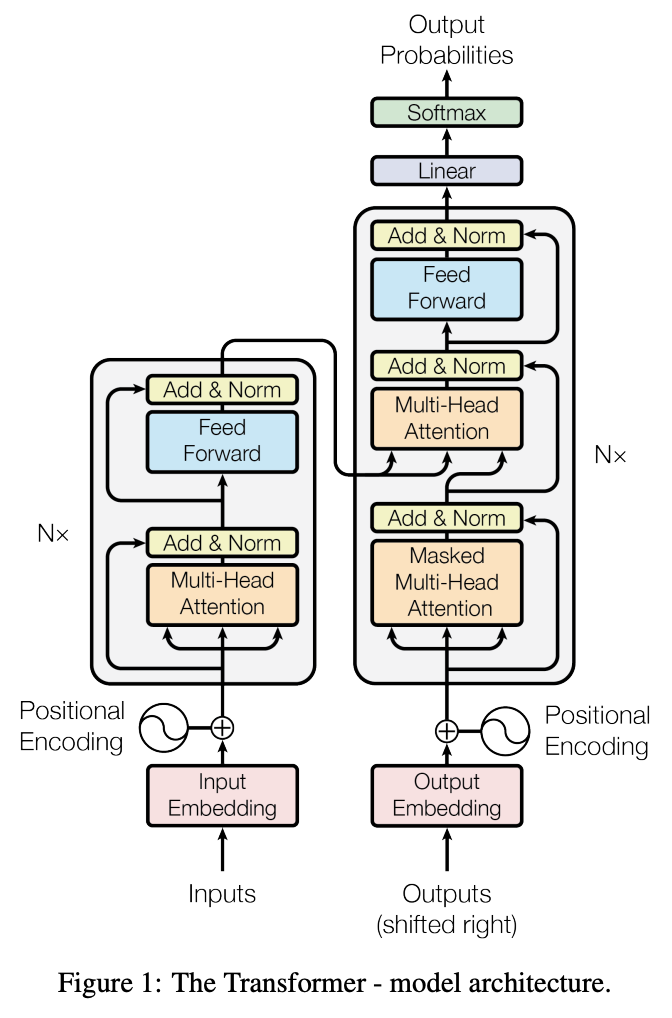

This is the architecture proposed by the Google researchers in the original paper.

**Embedding layers:** Embeddings are the inputs $x$ and outputs $y$ transformed as list of integers, before feeding them to the network.

**Softmax:** The softmax function takes as input a vector $z$ of $K$ real numbers, and normalizes it into a probability distribution consisting of $K$ probabilities proportional to the exponentials of the input numbers.

$$\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}$$

**Feed forward networks:** In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully
connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

$$FFN(x) = max(0, xW_1 + b_1)W_2 + b_2 $$

**Positional encoding:** Since our model contains no recurrence and no convolution, in order for the model to make use of the
order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. To this end, we add "positional encodings" to the input embeddings at the
bottoms of the encoder and decoder stacks.

In the paper, the sine and cosine functions of different frequencies are used:

$$PE_(pos,2i) = sin(pos / 10000^{2i} / d_{model})$$

$$PE_(pos,2i+1) = cos(pos / 10000^{2i} / d_{model})$$

**Multi head attention layers:** An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

Multi-head attention allows the model to jointly attend to information from different representation
subspaces at different positions. With a single attention head, averaging inhibits this.

$$MultiHead(Q, K, V ) = Concat(head_1, ..., head_h)W^O$$

where

$$head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)$$

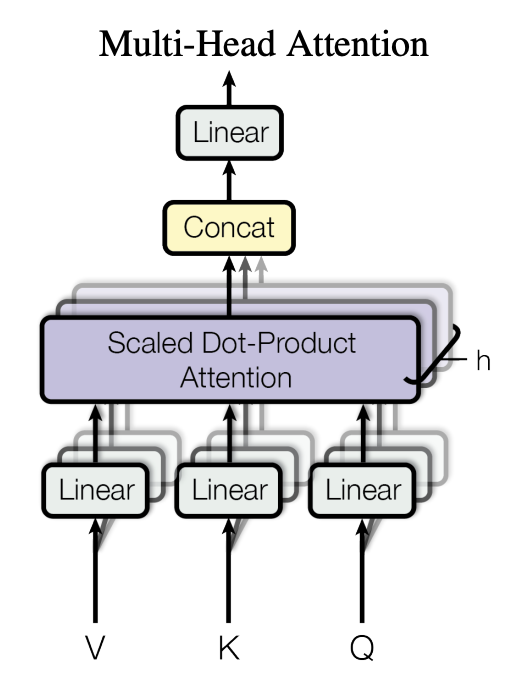

**Scaled dot product:** Computes the attention using Queries, Keys and Values.$$
\operatorname{Attention}(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}\right) V
$$
**Linear layer:** A simple layer of learnable neurons used to train the model. Only weights are used to train: $$y = w*x$$

**Feed forward layer:** A linear layer with bias: $$y = w*x + b$$

### Model applied to decompilation

As said earlier, decompilaiton can be seen as a translation task, where we want to translate a programming languagage $A$ to a programming language $B$. In other terms, we want to build a function $F$, when given the PL $A$ will result in the PL $B$: 

$$F(A) = B$$

This function $F$ can be for instance, a decompiler built on top of thousands or millions hand-written rules like [Ghidra](https://ghidra-sre.org/) or [Hopper](https://www.hopperapp.com/). However, **a piece of software like this takes months/years to develop because of the multitude of cases to take into account** when decompiling programming languages.

Another way to achieve this is to **use an approximation of the decompilation using Deep Learning** and especially a Transformer model in order to learn the patterns by itself and reproduce them when seeing new data.

### The Deepiler model

We've built a model named **Deepiler**, implementing the Transformer architecture developed in the paper *Attention is all you need* but modified and improved in order to be applied to decompilation tasks.

### Naive approach: using raw ASM code as input
The first naive approach we developed is to take the assembly code as is and feed it to the model.
The model can be initialized like so:

Note that the paper uses $N=6$ and $H=8$ but we prefer use $2$ for both for computation time reason.

In [15]:
from deepiler.model import DeepilerModel

model_size = 128 # size of embeddings
N = 2 # number of layers
H = 2 # number of stacked attention layers

model = DeepilerModel(tokenizer, dataset, model_size, \
    asm_path, c_path, nb_layers=N, h=H)

The model is initialized, let's train it. The number of `epochs` is the number of times the model will go threw the entire dataset. The `tqdm` library has been used to see graphically the time evolution during the training process.

In [16]:
epochs = 10 # number of passes in the dataset

model.train(epochs, verbose=False, predict=False)

100%|██████████| 282/282 [00:38<00:00,  7.36it/s]


The model is trained. We can see that several predictions has been done during training. It is now possible to test it on predictions. 

#### Perform a decompilation task
**The method `predict()` is the method performing the actual decompilation task**. It will go threw the trained encoder and decoder layers with as input the raw ASM Code and perform a prediction.
Using attention mechanism, the model is able to pick the matching C token with the most probability for each ASM token. Looping on all ASM tokens will result in a list of matching C tokens. Theses tokens are then concanated with spaces and reformated as the C code was before the preprocessing process (get rid of the spaces between tokens in order to match the same syntax as the solution C code).

**Important:** The predictions made with `predict()` are predictions made with examples which never appeared during the training step because they are picked from the testing dataset. So these predictions reflect use cases with new data that we could use in real life.

In [17]:
# Pick a random sample from the testing dataset to perform a prediction
model.predict(is_test_set=True, use_ast=False)

---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
c=fmax(c,e);
e=fdim(e,b);
if(islessgreater(b,c)){
d=(fmin(c,d))/(tan(e));
e=(acos(b))-(acos(e));
d=(acos(e))/(cos(b));
a=(log(a))*(ceil(b));
}
a=(fmin(b,b))*(pow(b,c));
b=pow(d,c);
d=(sin(b))/(pow(e,a));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double <end>
---------- BLEU score ----------
0.2190595177164556


'#include <stdio.h>\n#include <math.h>\n\nint main(){\ndouble a;\ndouble b;\ndouble c;\ndouble d;\ndouble e;\ndouble f;\ndouble g;\ndouble <end>'

The output performed by the model gives us multiple information. First, we see that the C syntax is respected, no syntax errors. Second, just a small part of the code has been predicted, we need to find another way to predict more accurately this code.

#### Evaluate the accuracy of the decompilation
Well, we now have a way to decompile our ASM code, but is it really accurate? Looking at the previous example, it does not seem to.

That's why we'll use a metric widely used in NLP to estimate if a translation task has been done correctly or not. This metric is the [BLEU score](https://en.wikipedia.org/wiki/BLEU).
The closer is this score to 1, the more the prediction is good, the more it is closer to à, the less the prediction is good. A BLEU score of 1 is a perfect match, meaning that the decompilation retrieved exactly all the C token

BLEU score is computed thanks to the `nltk` lib.

In [18]:
model.bleu_score # bleu score of the last prediction

0.2190595177164556

The BLEU score confirms that the prediction is bad.

### Advanced approach: using an AST
The results we got using the naive approach shows us it is possible to generate samples of C code with a corect C syntax but we did not achieve to obtain an enough good decompilation using rax ASM code.

In fact, the assembly code does not contain enough information regarding the structure and the links between lines of code. Also, the vocabulary built from the ASM files is quite huge and if we'd achieve to get a smaller vocabulary, we should make better predictions.

The solution to this problematic is the **Abstract Syntax Tree** (AST). An AST is a tree representation of a sequence of commands and operations. Using this structure, we have a better visualization of the structure of the program and the vocabulary will be reduced.

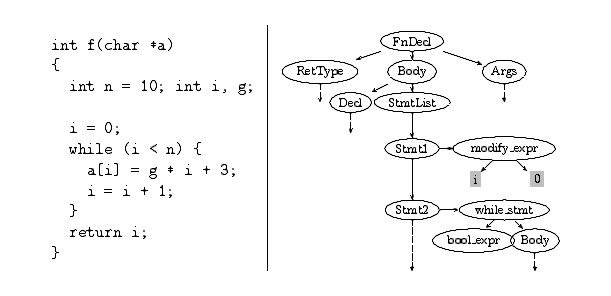

The previous schema is an example of AST built from C code. As C code is what we want to get from the decompilation, we won't use the AST for the C code but for the ASM code, in order to better learn the patterns and make better predictions.

Even if AST are used in every compilers, it is hard to find a reliable parser able to build ASTs and easily usable with Python. Some libraries like [eqfunc](https://github.com/AandersonL/eqfunc) need to know the address of the binary in memory in order to perform the AST construction so it is not efficient because we have to use directly the binaries insted of assembly code. [Angr with CFG](https://docs.angr.io/built-in-analyses/cfg) deal also with binaries directly and not assembly code.

Hopefully, [a program](https://github.com/facebookresearch/nbref/blob/main/preprocess/asm_mips.py) building AST from mips assembly has been done in a Facebook reasearch project on binary analysis. We'll use this program to build our AST from ASM code.

#### A new Tokenizer
We previously used a custom tokenizer (**RawCodeTokenizer**) for raw code manipulation. Now we'll use another custom tokenizer (**MipsTokenizer**) but this time for mips ASM code. This tokenizer will build the AST when using the `preprocess_dataset()` method.

##### Dataset loading

In [19]:
from deepiler.preprocessing import ASTTokenizer

tokenizer = ASTTokenizer("mips")
train_eval_ratio = .9
nb_files = 10_000

train_dataset = tokenizer.load_dataset(asm_path, c_path, is_train=True, \
    nb_files=nb_files, train_eval_ratio=train_eval_ratio)

##### Preprocessing

In [20]:
dataset = tokenizer.preprocess_dataset(train_dataset)

asm, c = next(dataset)
asm

'ins_addiu ins_addiu ins_sdc1 ins_sdc1 ins_addiu ins_sw ins_sw ins_addiu ins_sw ins_sw ins_addiu ins_move ins_move ins_addiu ins_sw ins_sw ins_addiu ins_ldc1 ins_ldc1 ins_addiu ins_jal ins_jal ins_addiu ins_ldc1 ins_ldc1 ins_addiu ins_sdc1 ins_sdc1 ins_addiu ins_ldc1 ins_ldc1 ins_addiu ins_jal ins_jal ins_addiu ins_ldc1 ins_ldc1 ins_addiu ins_sdc1 ins_sdc1 ins_addiu ins_jal ins_jal ins_addiu ins_ldc1 ins_ldc1 ins_addiu ins_sdc1 ins_sdc1 ins_addiu ins_jal ins_jal ins_addiu ins_ldc1 ins_ldc1 ins_addiu ins_mov.d ins_mov.d ins_addiu ins_jal ins_jal ins_addiu ins_ldc1 ins_ldc1 ins_addiu ins_add.d ins_add.d ins_addiu ins_j ins_j ins_addiu ins_sdc1 ins_sdc1 ins_addiu $BB0_1 $BB0_1 ins_addiu ins_ldc1 ins_ldc1 ins_addiu ins_jal ins_jal ins_addiu ins_mov.d ins_mov.d ins_addiu ins_beqz ins_beqz ins_addiu ins_nop ins_nop ins_addiu ins_j ins_j ins_addiu ins_nop ins_nop ins_addiu $BB0_3 $BB0_3 ins_addiu ins_ldc1 ins_ldc1 ins_addiu ins_jal ins_jal ins_addiu ins_ldc1 ins_ldc1 ins_addiu ins_sdc1 ins_sd

Looking at the previous output, **we can see the AST in a string format**. It is clear that the vocabulary size of this AST is far less than the previous greedy solution using raw code.

##### Tokenization

In [21]:
dataset = tokenizer.tokenize(dataset)
dataset

<TensorSliceDataset shapes: ((1788,), (373,), (373,)), types: (tf.int32, tf.int32, tf.int32)>

In [22]:
tokenizer.asm_tokenizer.word_counts

OrderedDict([('ins_addiu', 972448),
             ('ins_sdc1', 1206487),
             ('ins_sw', 360394),
             ('ins_move', 71992),
             ('ins_ldc1', 1267165),
             ('ins_jal', 507708),
             ('ins_mov.d', 309224),
             ('ins_sub.d', 65530),
             ('ins_j', 132224),
             ('$bb0_1', 24234),
             ('ins_beqz', 60025),
             ('ins_nop', 52080),
             ('$bb0_3', 36018),
             ('ins_add.d', 65420),
             ('$bb0_4', 30994),
             ('ins_lw', 130020),
             ('ins_jr', 26997),
             ('-88', 264539),
             ('$sp', 116136),
             ('$f20', 116572),
             ('80', 12457),
             ('$ra', 26997),
             ('76', 8444),
             ('$fp', 397292),
             ('72', 20403),
             ('$zero', 8999),
             ('68', 8538),
             ('$f12', 182942),
             ('32', 54415),
             ('fmax', 15684),
             ('$f14', 90823),
             ('5

##### Batch

In [23]:
batch_size = 32
dataset = dataset.shuffle(nb_files).batch(batch_size)

##### Model creation and training

In [24]:
model_size = 128
N = 2
H = 2
model = DeepilerModel(tokenizer, dataset, model_size, \
    asm_path, c_path, nb_layers=N, h=H)

epochs = 25
model.train(epochs, verbose=True)

Epoch 1 Loss 0.5252: 100%|██████████| 282/282 [01:29<00:00,  3.13it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
e=fmin(f,e);
f=fmax(e,b);
b=(exp(f))*(exp(c));
b=(ceil(c))-(log(b));
f=exp(a);
while(islessequal(e,e)){
f=pow(b,b);
c=sin(b);
}
if(islessgreater(b,f)){
d=fmin(d,b);
a=log10(e);
c=(fdim(c,a))*(fmin(e,d));
d=floor(f);
d=fmax(c,c);
}
else{
c=(floor(a))-(fmax(a,b));
d=acos(f);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
c=(fmax(d);
d=(d);
d=(pow(d);
b=(d);
d=(d);
d=(d);
c=(fmin(b);
if(b));
e=(e);
e=(fmax(e)));
d=(d));
d=(pow(b);
e=(d);
e=(fmin(b);
d=(d);
c=(e);
b=(e);
b=(pow(e)));
e=(d);
c=(d);
b=(e);
e=(e);
d=(e);
d=(d);
}
} <end>
---------- BLEU score ----------
0.5394134267415305


Epoch 2 Loss 0.5101: 100%|██████████| 282/282 [01:23<00:00,  3.39it/s]


Average elapsed time: 89.63s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
f=(fmin(c,e))-(pow(a,h));
e=fmin(e,g);
while(islessgreater(c,d)){
g=(fmax(d,a))-(atan2(c,f));
e=atan(c);
}
a=exp(b);
f=fmin(d,g);
h=log(d);
d=ceil(c);
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
d=(pow(d,a);
e=(pow(f,f);
c=(pow(d,g);
b=(pow(d,d);
while(islessgreater(d);
e=(pow(d,a);
c=(fmin(d));
a=(pow(d,d));
e=(pow(b);
e=(fmin(d,d);
}
} <end>
---------- BLEU score ----------
0.7321366206941677


Epoch 3 Loss 0.5122: 100%|██████████| 282/282 [01:23<00:00,  3.39it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
b=atan2(d,b);
b=(fdim(d,c))-(pow(c,e));
a=floor(e);
f=(log(d))+(fmin(e,a));
b=(exp(a))*(fmin(e,b));
while(islessequal(e,d)){
e=(pow(b,c))+(fmax(b,b));
a=acos(e);
}
while(isgreaterequal(b,b)){
a=(tan(a))*(log(a));
a=atan2(a,d);
b=(ceil(c))/(log10(a));
f=fdim(f,c);
b=(log10(a))+(asin(b));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
c=(pow(b,a))*(atan2(b,a));
c=(pow(b,a))-(fmax(b,a));
c=(atan2(b,b))*(atan2(b,b));
b=(pow(b,b))*(pow(b,b));
b=(atan2(b,b))*(atan2(b,b));
a=(pow(b,a))+(atan2(b,b));
c=(pow(c,b))*(pow(b,b));
c=(pow(c,b))/(atan2(a,a));
a=(pow(a,b))-(atan2(b,b));
}
} <end>
---------- BLEU score ----------
0.5480704031329888


Epoch 4 Loss 0.4361: 100%|██████████| 282/282 [01:23<00:00,  3.39it/s]


Average elapsed time: 89.05s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
d=pow(f,c);
e=acos(d);
f=(fdim(c,c))+(cos(f));
d=(ceil(c))*(sqrt(d));
a=(log(f))-(fmin(b,b));
b=acos(d);
while(isless(c,e)){
e=(fmax(e,f))+(fdim(d,b));
d=pow(d,a);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
c=(fdim(b,c))*(fdim(b,c));
b=(fdim(b,c))*(fdim(c,c));
b=(fdim(b,b))*(fdim(c,c));
b=(fdim(b,b))*(fmax(c,c));
b=(fdim(b,c))*(fdim(e,e));
b=(fdim(e,c))*(fdim(e,c));
} <end>
---------- BLEU score ----------
0.6173243961589616


Epoch 5 Loss 0.3344: 100%|██████████| 282/282 [01:23<00:00,  3.39it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
b=(cos(b))+(fmin(b,e));
g=(fmin(e,c))/(fdim(c,e));
while(islessgreater(g,g)){
b=(pow(a,d))/(sin(d));
e=(fmax(e,f))-(pow(e,d));
g=(fmax(e,a))/(sin(c));
g=(atan(h))/(atan2(a,c));
}
while(isgreaterequal(c,h)){
b=(cos(f))+(exp(f));
c=cos(c);
c=(log10(b))*(ceil(b));
d=fmin(a,e);
b=(log(f))+(log10(h));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
c=(fmin(d,a))/(fmin(a,a));
c=(pow(f,a))/(pow(a,a));
c=(fdim(a,a))/(fmin(a,a));
if(isless(a,a)){
c=(fmin(a,a))/(pow(a,a));
g=(fmax(a,a))/(fmax(a,a));
e=(fmax(a,a))/(atan2(a,a));
e=(fmin(a,a))/(fmin(a,a));
b=(atan(a))/(fmin(e,a));
a=(fmax(a,a))/(atan(e));
b=(fmax(e,e));
}
} <end>
---------- BLEU score ----------
0.6264471997481662


Epoch 6 Loss 0.3949: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 89.05s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
c=(fdim(f,b))/(tan(d));
f=(pow(b,a))-(fmax(d,d));
while(isless(f,b)){
a=fmin(d,e);
b=fmax(f,b);
b=(fmax(c,b))+(fdim(b,b));
}
if(islessequal(c,b)){
d=(sin(c))+(acos(d));
d=cos(c);
d=(pow(d,e))-(fmax(b,d));
c=(atan(a))/(cos(b));
d=(fmax(a,a))-(fmax(e,a));
}
else{
f=atan2(a,c);
a=acos(b);
b=floor(c);
e=(fmin(f,d))-(fmax(b,f));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
d=(fmax(a,a))*(fmax(a,a));
d=(fmax(b,a))*(fmax(a,a));
if(islessequal(a,a)){
c=(fmax(a,a))/(fmax(a,a));
d=(fmax(a,a))-(fmax(a,a));
a=(fmax(a,a))-(fmin(a,a));
a=(fmax(d,a))/(fmax(a,a));
a=(fmax(a,a))-(fmax(a,a));
a=(atan2(a,a))-(fmax(d,a));
a=(fdim(a,a))-(fmax(a,a));
b=(fmax(d,a))-(fmax(a,a));
}
} <end>
---------- BLEU score ----------
0.6071019538179314


Epoch 7 Loss 0.4016: 100%|██████████| 282/282 [01:23<00:00,  3.39it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
c=(fmin(b,a))+(floor(d));
b=(exp(b))+(floor(c));
b=log(g);
d=fmin(d,g);
f=(pow(e,b))+(fdim(c,e));
e=(atan2(g,c))*(atan2(e,a));
f=(sin(e))/(exp(c));
c=(sin(d))*(asin(c));
c=atan2(f,d);
e=(floor(c))+(fmin(g,g));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
d=(fdim(c,c))/(fmax(f,c));
d=(fmax(f,f))/(fmax(e,f));
d=(fmax(f,f))/(fmax(f,f));
d=(fmax(f,f))+(fmax(f,f));
b=(fmax(f,f))+(fmax(f,f));
f=(fdim(f,f))+(fdim(f,f));
f=(fmax(f,e))/(fmax(d,e));
c=(fmax(f,f))*(fmax(f,c));
} <end>
---------- BLEU score ----------
0.5850055018779948


Epoch 8 Loss 0.4216: 100%|██████████| 282/282 [01:23<00:00,  3.39it/s]


Average elapsed time: 89.23s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
c=(fmin(a,c))-(fdim(e,d));
a=fdim(a,b);
b=(acos(a))-(fdim(a,b));
c=(atan(b))*(tan(b));
c=exp(c);
c=(fdim(e,d))-(floor(b));
d=(sin(c))*(atan(b));
b=(atan2(d,b))+(tan(a));
if(islessequal(c,d)){
c=(fdim(a,d))-(fmin(a,a));
d=sin(d);
e=(fmax(c,b))-(sin(b));
d=(fdim(a,c))+(asin(c));
e=(atan2(e,a))+(exp(b));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
d=(fmin(a,a))+(fmin(a,a));
a=(fmin(a,a))*(fmin(a,a));
a=(fmin(a,a))+(fmin(a,a));
if(islessequal(a,a)){
e=(fmin(a,a))+(fmin(a,b));
a=(fmin(a,a))-(fmin(a,a));
a=(fmin(a,a))+(fmin(a,a));
d=(pow(a,a))+(pow(a,a));
d=(fmin(a,a))+(fmin(a,a));
a=(fmin(a,a))+(fmin(a,a));
d=(fmax(a,a))+(fmin(a,a));
}
} <end>
---------- BLEU score ----------
0.5722335652645574


Epoch 9 Loss 0.4477: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
d=(atan(c))+(ceil(d));
e=(fdim(c,d))+(pow(c,a));
a=pow(e,c);
if(islessequal(e,a)){
e=(fdim(b,e))-(pow(a,a));
d=(pow(e,b))/(fmax(d,d));
}
d=(exp(e))+(log(a));
c=fmax(c,d);
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
a=(fmax(b,e);
d=(fmin(b,b))/(pow(b,e));
a=(fmax(b,b))*(atan2(b,b));
a=(fmax(e,e))*(fmax(b,b));
a=(pow(b,b))+(fmin(b,b));
a=(fdim(f,f));
a=(fmin(b,b))+(pow(b,b));
}
} <end>
---------- BLEU score ----------
0.6123585709555002


Epoch 10 Loss 0.3817: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 89.23s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
h=(atan(f))-(pow(g,c));
d=(fdim(d,c))/(sqrt(g));
g=ceil(c);
while(isless(d,e)){
h=(atan(c))/(cos(e));
f=(ceil(b))*(fmin(g,g));
g=(pow(c,c))-(log10(a));
}
h=(fmax(h,a))*(sin(f));
f=pow(e,c);
a=(pow(a,a))/(sin(b));
c=exp(c);
a=log(a);
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
g=(fmax(g,g))/(fmin(g,g));
g=(fdim(g,g))*(fmax(g,g));
g=(fdim(g,g))+(fmin(g,g));
g=(fdim(g,c))*(fmin(g,g));
a=(fmin(g,g))*(atan2(g,g));
a=(atan2(g,g))-(fmin(g,c));
g=(atan2(g,g))-(atan2(g,g));
a=(fmin(g,g))+(fdim(g,g));
}
} <end>
---------- BLEU score ----------
0.6153136341486707


Epoch 11 Loss 0.3921: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
c=fdim(d,b);
b=log10(c);
d=(atan2(d,a))-(log10(d));
a=(fmin(e,b))+(atan(c));
e=fdim(d,d);
e=fdim(d,b);
e=(fdim(c,c))-(acos(a));
e=floor(a);
a=fmin(b,c);
c=fmax(e,c);
d=(exp(c))*(log10(c));
d=(log(c))*(log(c));
d=(log(d))-(atan2(a,c));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
c=(fdim(d,d))+(atan2(c,c));
a=(fdim(d,c))*(fmax(c,c));
a=(fdim(c,c))*(fmin(c,c));
b=(fdim(b,b))/(fdim(d,b));
e=(fdim(b,c))+(fmin(c,c));
b=(fdim(b,c))+(fmax(e,b));
a=(fdim(c,c))+(fdim(e,c));
a=(fdim(c,c))-(fdim(b,e));
} <end>
---------- BLEU score ----------
0.6505758758245583


Epoch 12 Loss 0.3748: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 89.21s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
c=atan2(f,a);
e=fmax(g,g);
c=(fmin(f,c))/(asin(c));
c=(acos(g))-(sqrt(g));
f=(fdim(e,e))*(log(d));
g=pow(b,d);
b=log10(b);
while(isgreaterequal(c,c)){
c=(atan2(g,a))*(atan2(a,g));
e=(log10(g))*(fdim(g,f));
c=tan(c);
b=(fdim(d,c))*(sqrt(e));
a=(atan2(g,b))+(log10(c));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
c=(fmin(a,a))/(fmin(a,a));
e=(fmin(a,a))/(fmin(a,a));
b=(fmin(a,a))/(fmin(a,a));
d=(fmin(a,a))/(fmin(a,a));
b=(fmin(a,a))/(fmin(a,a));
while(isgreaterequal(d,a)){
b=(pow(a,a))/(pow(a,a));
e=(pow(a,a))/(atan2(a,a));
e=(pow(a,a))/(pow(a,a));
}
} <end>
---------- BLEU score ----------
0.5761815465503151


Epoch 13 Loss 0.4183: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
c=(exp(h))+(fmin(e,g));
b=(atan2(h,b))/(atan2(g,g));
f=fmin(h,d);
h=fmin(b,e);
c=exp(f);
c=fdim(f,f);
e=(tan(g))+(asin(c));
while(isgreaterequal(d,b)){
e=acos(g);
h=(asin(c))+(pow(e,e));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
g=(fmin(c,c))+(fmin(c,c));
h=(fmin(b,b))+(fmin(c,c));
g=(fmin(c,c))+(fmin(c,b));
while(isgreaterequal(b,c)){
g=(fmin(b,b))+(fmin(b,b));
g=(fmin(b,b))*(fmin(c,b));
g=(fmin(c,c))*(fmin(c,b));
}
} <end>
---------- BLEU score ----------
0.6527145398696206


Epoch 14 Loss 0.4193: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 89.17s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
h=acos(f);
d=(fmax(e,c))+(atan2(g,d));
if(islessgreater(d,c)){
g=(cos(g))*(tan(b));
c=(fmin(g,b))+(sqrt(h));
g=tan(c);
}
else{
h=fmax(f,e);
g=(atan2(f,h))/(atan2(f,e));
a=(asin(b))-(exp(f));
}
if(islessequal(e,d)){
d=(fdim(a,h))+(atan(e));
f=pow(g,e);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
f=(pow(e,e))/(pow(c,c));
f=(pow(e,d))*(fdim(c,c));
while(isgreaterequal(c,d)){
f=(fmax(e,c))/(fmax(d,c));
g=(fmax(c,c))*(pow(d,d));
f=(fmax(e,e))/(fmax(d,d));
}
while(isgreaterequal(d,d)){
e=(pow(c,c))*(atan2(c,c));
g=(atan2(d,d))*(fmax(e,e));
}
} <end>
---------- BLEU score ----------
0.6459459901684994


Epoch 15 Loss 0.4019: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
a=ceil(e);
d=asin(a);
c=atan2(a,g);
e=tan(b);
a=sin(g);
if(isgreaterequal(a,f)){
g=atan2(e,d);
e=(fmax(f,f))+(cos(a));
c=(acos(c))*(ceil(c));
}
else{
e=atan2(a,e);
b=(sin(c))+(atan2(b,e));
}
e=fdim(a,b);
b=(fdim(g,c))*(log(d));
a=(acos(c))+(atan2(f,d));
d=sqrt(g);
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
f=(atan2(g,e))/(atan2(g,g));
e=(fmin(e,e))*(fmin(e,e));
c=(fdim(g,g))/(atan2(e,e));
if(islessgreater(g,g)){
c=(fdim(g,g))*(atan2(g,g));
d=(fdim(c,g))-(fmax(d,c));
d=(fdim(g,g))/(fdim(g,g));
d=(atan2(g,g))/(fdim(g,e));
f=(fmax(g,g))/(fdim(c,g));
}
} <end>
---------- BLEU score ----------
0.6106254591350162


Epoch 16 Loss 0.4219: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 89.18s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
b=(cos(b))-(cos(e));
a=fdim(e,e);
e=sin(a);
d=log10(b);
e=floor(c);
if(islessequal(a,b)){
b=acos(d);
b=fmax(a,d);
e=(acos(d))-(atan2(d,b));
c=(fdim(d,a))/(atan2(e,c));
a=floor(e);
}
else{
c=(log10(d))-(fmax(c,b));
d=log10(d);
b=(fmax(c,c))-(asin(e));
c=(ceil(c))+(fdim(c,b));
a=cos(e);
}
if(islessgreater(b,b)){
e=fmax(e,d);
a=(sin(e))/(fdim(a,b));
b=atan(b);
d=atan2(e,c);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
c=(atan2(d,d))-(pow(d,d));
c=(fmin(d,d))-(atan2(d,d));
c=(atan2(d,d))-(fmin(d,d));
if(isgreaterequal(d,d)){
e=(fmin(d,d))-(fmin(d,d));
c=(fmin(d,d))-(fdim(d,d));
a=(fmax(d,d))-(atan2(d,d));
}
else{
b=(fdim(d,d))-(pow(d,d));
c=(fmin(d,d))+(fmin(d,d));
c=(fmin(d,d))+(atan2(d,d));
d=(atan2(d,d))+(pow(d,d));
d=(fmin(d,d))+(fdim(d,d

Epoch 17 Loss 0.3778: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
b=(fmax(e,f))-(cos(e));
f=atan2(c,c);
f=sqrt(e);
c=pow(f,d);
if(isgreaterequal(c,c)){
e=pow(d,c);
f=(fdim(b,b))+(fmin(b,d));
f=(asin(c))-(pow(c,f));
c=(exp(c))+(fdim(a,c));
e=(cos(d))-(log10(c));
}
else{
a=(atan2(b,a))-(pow(e,e));
a=pow(b,f);
b=(asin(e))*(acos(d));
}
while(isless(f,d)){
e=tan(b);
c=pow(b,e);
f=atan2(a,c);
f=pow(a,b);
e=pow(c,f);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
e=(fdim(c,c))-(atan2(c,c));
c=(atan2(c,c))*(fdim(c,c));
c=(fdim(c,c))*(fdim(c,c));
if(isgreaterequal(c,c)){
c=(fdim(c,c))*(atan2(c,c));
e=(fdim(c,c))*(atan2(c,c));
e=(fdim(c,c))*(fdim(c,c));
}
if(isgreaterequal(c,c)){
e=(pow(c,e))-(fdim(c,c));
e=(pow(c,c))-(atan2(c,c));
e=(atan2(c,c))*(fdim(c,c));
a=(fdim(c,c))-(fdim(e,c));
}
} <end>
---------- BLEU sc

Epoch 18 Loss 0.3926: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 89.39s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
d=(pow(c,f))+(sqrt(d));
b=floor(a);
b=(pow(a,f))+(fmin(a,c));
e=fdim(d,e);
f=(atan2(b,e))/(fdim(d,a));
b=pow(a,e);
e=ceil(b);
c=tan(a);
e=(tan(d))-(pow(d,a));
d=fdim(b,b);
e=(sin(e))+(pow(b,b));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
d=(fmax(d,d))+(fmax(a,d));
b=(pow(a,d))+(fmax(d,d));
d=(pow(d,a))+(pow(d,a));
b=(pow(a,a))*(pow(a,a));
b=(pow(a,a))*(fmin(d,d));
d=(pow(d,d))*(pow(d,d));
b=(pow(d,d))*(pow(d,d));
b=(pow(d,d))*(pow(d,d));
} <end>
---------- BLEU score ----------
0.620152750377452


Epoch 19 Loss 0.3249: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
f=(pow(e,e))+(acos(b));
f=pow(e,d);
e=(sqrt(d))-(atan(d));
c=(log10(d))*(fmin(e,a));
if(isless(e,e)){
d=(floor(b))-(log(f));
e=(atan2(c,d))/(fmax(a,d));
c=(atan(b))+(fmin(c,e));
c=(atan2(a,a))*(atan(d));
a=(ceil(a))+(fdim(e,d));
}
if(islessgreater(c,f)){
b=sqrt(f);
b=pow(a,a);
c=(tan(d))-(cos(b));
}
else{
b=(fdim(f,e))+(atan2(a,c));
e=sin(a);
c=ceil(a);
d=fdim(a,d);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
d=(atan2(b,b))+(atan2(b,b));
b=(pow(b,b))-(atan2(e,e));
e=(atan2(b,b))*(pow(e,b));
if(islessequal(b,b)){
d=(fmax(e,e))-(fmax(e,b));
b=(atan2(e,e))*(fmax(e,e));
e=(pow(e,b))+(pow(b,b));
e=(pow(b,b))+(pow(b,b));
}
if(isgreaterequal(a,a)){
d=(pow(e,a))+(atan2(a,a));
d=(atan2(b,a))*(atan2(a,b));
a=(atan2(a,a))+(atan2(e,a));
e=(atan2(a,a))+(fdim(

Epoch 20 Loss 0.3517: 100%|██████████| 282/282 [02:21<00:00,  1.99it/s]


Average elapsed time: 92.41s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
f=cos(f);
f=fmin(e,d);
c=(sin(a))-(atan2(e,a));
b=pow(a,c);
c=tan(d);
while(isgreaterequal(e,e)){
c=fmin(d,a);
e=(fmax(d,b))/(asin(f));
b=(log(b))-(exp(e));
}
d=(pow(e,b))/(tan(a));
a=fmin(c,d);
d=(fmax(f,e))+(floor(a));
b=ceil(e);
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
b=pow(d,d);
d=(pow(d,d))-(pow(d,d));
b=(pow(d,d))-(pow(d,d));
while(isless(d,d)){
a=(pow(d,d))*(pow(d,d));
e=(pow(d,d))/(pow(d,d));
e=(pow(d,d))/(pow(d,d));
}
e=(pow(d,d))+(pow(d,d));
e=(pow(d,d))+(pow(d,d));
} <end>
---------- BLEU score ----------
0.5455669153121571


Epoch 21 Loss 0.3343: 100%|██████████| 282/282 [02:21<00:00,  1.99it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
e=(atan2(b,b))-(fdim(e,e));
c=(acos(c))*(atan2(e,d));
if(isgreaterequal(c,e)){
c=(fmax(e,a))*(fmin(b,c));
d=(sin(e))*(fmax(d,d));
c=(asin(d))*(fdim(b,b));
}
e=(sqrt(d))-(acos(b));
c=(asin(b))-(floor(e));
a=asin(b);
d=(fmax(b,c))/(fdim(a,d));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
a=(fmax(a,a))-(fdim(a,a));
c=(fmin(a,a))*(fmax(a,a));
if(isgreaterequal(e,b)){
d=(fdim(a,e))*(fmax(a,e));
a=(fmax(a,a))*(fmax(e,e));
a=(fdim(e,e))*(fdim(a,e));
}
a=(fmax(e,a))-(fmax(a,a));
a=(fmax(a,a))/(fmax(a,a));
c=(fmax(a,a))/(fmax(b,b));
} <end>
---------- BLEU score ----------
0.6844155448187172


Epoch 22 Loss 0.3706: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 94.78s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
f=(cos(c))-(fmax(c,c));
e=(sin(c))/(cos(f));
c=(pow(d,f))+(sqrt(b));
f=atan(a);
f=pow(c,d);
if(isgreaterequal(e,e)){
c=pow(d,a);
c=(pow(a,f))+(log10(e));
b=log(e);
b=tan(c);
}
while(islessgreater(b,b)){
b=(pow(b,d))/(pow(e,a));
b=floor(a);
f=(sin(e))+(floor(e));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
c=(fmin(f,e))-(fmax(f,f));
e=(pow(e,e))/(atan2(e,e));
a=(pow(e,f))+(pow(f,e));
a=pow(f,f);
if(isless(e,e)){
e=pow(f,e);
a=(pow(f,e))+(pow(f,e));
d=pow(e,e);
}
else{
a=pow(f,f);
e=(pow(f,e))*(pow(e,f));
}
while(islessgreater(e,e)){
b=(atan2(e,e))+(atan2(f,e));
}
} <end>
---------- BLEU score ----------
0.6511506206685342


Epoch 23 Loss 0.2410: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
a=log10(b);
f=fdim(b,c);
a=(floor(c))/(tan(d));
e=atan2(b,e);
b=exp(d);
a=(ceil(d))/(pow(d,c));
if(isless(f,b)){
a=atan2(e,f);
e=fmin(b,c);
c=fdim(c,a);
f=atan2(e,d);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
d=tan(c);
d=fdim(b,c);
d=(tan(c))/(tan(c));
d=atan2(c,c);
e=exp(c);
d=(exp(c))/(pow(c,c));
if(isless(c,c)){
d=atan2(c,c);
e=fmin(c,c);
d=fdim(c,c);
d=atan2(c,c);
}
} <end>
---------- BLEU score ----------
0.7470179451709145


Epoch 24 Loss 0.1892: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 94.27s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
c=(asin(e))*(fmin(a,c));
a=(atan(d))*(fdim(b,b));
b=(sqrt(b))/(cos(a));
a=fmin(e,b);
e=(log(e))*(pow(b,b));
d=atan(b);
d=fmin(c,c);
d=pow(d,a);
a=atan2(e,b);
a=(pow(c,c))-(fdim(e,b));
if(islessgreater(b,a)){
b=sqrt(e);
a=(fmin(c,c))*(tan(c));
e=(fdim(d,d))*(pow(d,d));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
b=(asin(b))*(fmin(b,b));
b=(atan(b))*(fdim(b,b));
b=(sqrt(e))/(fmin(b,b));
b=fmin(e,e);
b=(log(e))*(atan(e));
c=atan(b);
c=pow(b,e);
b=pow(b,b);
b=atan2(b,e);
b=(fdim(e,e))-(fdim(e,e));
if(islessgreater(e,e)){
e=sqrt(e);
b=(fmin(b,b))*(fdim(b,e));
a=(pow(b,b))*(pow(e,e));
}
} <end>
---------- BLEU score ----------
0.7673475635247481


Epoch 25 Loss 0.2097: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
b=fmax(b,d);
g=ceil(d);
a=(pow(f,a))*(asin(a));
c=fdim(e,e);
c=(sin(d))/(log(f));
f=pow(b,e);
e=(asin(b))+(fmin(d,b));
c=(pow(a,f))+(log(e));
d=(sqrt(d))-(fmin(f,a));
d=log10(a);
b=(log10(d))/(asin(f));
f=(fmin(g,f))-(fmin(c,f));
c=(cos(d))*(ceil(c));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
c=fmax(c,c);
f=ceil(f);
f=(ceil(f))*(pow(f,f));
g=fdim(f,f);
e=(sin(f))/(log(f));
g=pow(f,f);
c=(asin(f))+(fmin(f,c));
a=(pow(f,c))+(log(c));
c=(sqrt(c))-(fmin(c,c));
a=log10(c);
b=(log10(c))/(asin(e));
e=asin(f);
f=(fmin(g,e))-(fmin(e,c));
e=(cos(e))*(ceil(f));
} <end>
---------- BLEU score ----------
0.7980102945886198


This model looks really promising, we achieved a really high bleu score on most of the last epochs and when looking at the prediction, **the decompilation looks really successfull**.

In [25]:
# pick a random never-seen ASM example and decompile it
model.predict()

---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
f=(fdim(e,c))+(ceil(g));
d=(pow(g,a))/(acos(f));
c=exp(d);
f=(fmax(f,a))/(pow(f,g));
if(isless(f,g)){
e=(sin(c))-(atan2(d,b));
g=pow(g,b);
b=(atan2(g,f))*(fmax(d,f));
a=fmax(g,g);
}
while(isgreaterequal(f,b)){
d=fmin(d,f);
g=fdim(f,a);
c=tan(e);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
g=(fdim(e,f))+(ceil(g));
g=(pow(g,g))/(acos(g));
c=exp(g);
g=(fmax(g,g))/(pow(g,g));
if(isless(g,g)){
g=(sin(f))-(atan2(f,f));
f=pow(g,g);
f=(atan2(g,g))*(fmax(g,e));
f=fmax(g,g);
}
while(isgreaterequal(e,e)){
g=fmin(e,e);
f=fmin(b,a);
f=tan(g);
}
} <end>
---------- BLEU score ----------
0.8179189490345568


'#include <stdio.h>\n#include <math.h>\n\nint main(){\ndouble a;\ndouble b;\ndouble c;\ndouble d;\ndouble e;\ndouble f;\ndouble g;\ng=(fdim(e,f))+(ceil(g));\ng=(pow(g,g))/(acos(g));\nc=exp(g);\ng=(fmax(g,g))/(pow(g,g));\nif(isless(g,g)){\ng=(sin(f))-(atan2(f,f));\nf=pow(g,g);\nf=(atan2(g,g))*(fmax(g,e));\nf=fmax(g,g);\n}\nwhile(isgreaterequal(e,e)){\ng=fmin(e,e);\nf=fmin(b,a);\nf=tan(g);\n}\n} <end>'

In [26]:
model.bleu_score

0.8179189490345568

### Saving the model weights on disk
A model takes time to learn. When we have achieved good predictions on a model, it is good pratice to save the weights of that model to a file in order to load it back again. That's why the Deepiler model has a `model()` and `load()` methods in order to save compute time for later predictions.

In [27]:
model.save("save")

Model saved.


After running `save()`, a folder containing 2 files is created, these files are the weights for encoder and decoder layers. When these layers are bringing back to life with `load()` it is possible to going threw all the weights and make predictions like before.

In [28]:
!ls save

decoder.h5  encoder.h5


### Loading the model back from disk

The model is saved on disk. We can now load it back using `load()` with argument the path to the saved folder.
A `DeepilerModel` object needs to be instantiated before in order to access all the needed variables in the model.

In [29]:
loaded_model = DeepilerModel(tokenizer, dataset, model_size, \
    asm_path, c_path, nb_layers=N, h=H)
loaded_model.load("save")

100%|██████████| 282/282 [01:28<00:00,  3.18it/s]


Model loaded.


Make a new prediction to be sure the model is correctly loaded.

In [30]:
loaded_model.predict()

---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
c=atan2(a,f);
b=(atan2(a,d))-(acos(g));
f=log(a);
f=pow(g,e);
f=sqrt(d);
d=(sin(d))+(pow(g,a));
f=(sin(e))*(ceil(d));
if(islessgreater(g,f)){
f=(fmax(d,a))+(acos(g));
g=(atan2(d,a))/(asin(b));
b=(log(e))/(cos(a));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
c=atan2(a,a);
f=(atan2(e,f))-(acos(f));
g=log(f);
g=pow(f,f);
g=sqrt(f);
c=(sin(f))+(pow(f,f));
c=(sin(f))*(ceil(f));
if(islessgreater(f,f)){
f=(fmax(g,g))+(acos(g));
f=atan2(f,f);
g=(asin(e))/(asin(g));
g=(acos(e))/(cos(e));
}
} <end>
---------- BLEU score ----------
0.793091653108462


'#include <stdio.h>\n#include <math.h>\n\nint main(){\ndouble a;\ndouble b;\ndouble c;\ndouble d;\ndouble e;\ndouble f;\ndouble g;\nc=atan2(a,a);\nf=(atan2(e,f))-(acos(f));\ng=log(f);\ng=pow(f,f);\ng=sqrt(f);\nc=(sin(f))+(pow(f,f));\nc=(sin(f))*(ceil(f));\nif(islessgreater(f,f)){\nf=(fmax(g,g))+(acos(g));\nf=atan2(f,f);\ng=(asin(e))/(asin(g));\ng=(acos(e))/(cos(e));\n}\n} <end>'

It is also possible to train again the model after loading if we want to optimize it again.

In [31]:
epochs = 15
loaded_model.train(epochs)

Epoch 1 Loss 0.2289: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
e=pow(a,e);
e=(ceil(f))+(atan(a));
b=(ceil(e))+(fdim(b,d));
if(isless(c,d)){
d=(log10(e))-(exp(b));
e=log(e);
}
f=acos(b);
f=asin(d);
c=fmin(b,b);
f=(floor(a))/(ceil(e));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
e=pow(e,e);
e=(ceil(f))+(atan(e));
e=(ceil(b))+(fdim(b,b));
if(isless(b,b)){
b=(log10(a))-(exp(b));
f=log(b);
}
a=acos(f);
f=asin(f);
f=fmin(e,e);
e=(floor(a))/(ceil(e));
} <end>
---------- BLEU score ----------
0.880093927724118


Epoch 2 Loss 0.1478: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 85.53s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
c=sin(b);
a=fmin(f,a);
b=(atan2(f,b))*(atan(f));
a=cos(b);
e=(log10(b))*(atan(b));
a=tan(e);
if(islessequal(d,a)){
b=(floor(b))/(atan(f));
a=pow(d,d);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
b=sin(e);
b=fmin(f,e);
f=(atan2(f,f))*(atan(f));
b=cos(e);
b=(log10(c))*(atan(e));
b=tan(e);
if(islessequal(a,a)){
b=(floor(f))/(atan(f));
b=pow(c,a);
}
} <end>
---------- BLEU score ----------
0.8417358302740723


Epoch 3 Loss 0.1763: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
c=fmin(a,f);
c=(ceil(d))*(cos(c));
a=(asin(c))*(fmax(e,f));
e=(atan2(b,b))*(acos(a));
if(islessequal(e,c)){
a=fdim(f,b);
d=pow(a,b);
d=fmax(c,e);
d=(atan(c))/(sqrt(f));
f=atan(c);
}
else{
d=ceil(e);
b=fmax(b,d);
a=(pow(e,d))/(pow(d,f));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
f=fmin(f,a);
f=(ceil(d))*(cos(c));
e=(asin(e))*(fmax(f,a));
e=(atan2(a,a))*(acos(e));
if(islessequal(f,f)){
b=fdim(a,a);
e=pow(a,a);
e=fmax(d,e);
e=(atan(e))/(sqrt(e));
b=atan(f);
}
b=fmax(e,d);
e=(fmax(e,e))/(pow(d,e));
c=pow(a,a);
}
} <end>
---------- BLEU score ----------
0.791051953618685


Epoch 4 Loss 0.1902: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 86.84s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
e=(atan2(a,a))-(log(a));
g=sqrt(e);
d=(atan(c))/(asin(d));
while(isgreaterequal(a,f)){
f=fmin(c,e);
a=fdim(c,e);
e=(fdim(c,d))*(sqrt(a));
g=fdim(a,f);
c=tan(c);
}
g=(floor(a))*(fmin(e,e));
a=ceil(e);
g=asin(f);
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
c=(atan2(a,a))-(log(a));
c=sqrt(g);
c=(atan(c))/(asin(d));
while(isgreaterequal(a,f)){
d=fmin(f,c);
f=fdim(f,c);
f=(fdim(b,c))*(sqrt(a));
f=fdim(a,g);
f=tan(d);
}
f=(floor(a))*(fmin(e,e));
f=ceil(g);
d=asin(f);
} <end>
---------- BLEU score ----------
0.8549602366349893


Epoch 5 Loss 0.1271: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
f=(fdim(e,c))+(ceil(g));
d=(pow(g,a))/(acos(f));
c=exp(d);
f=(fmax(f,a))/(pow(f,g));
if(isless(f,g)){
e=(sin(c))-(atan2(d,b));
g=pow(g,b);
b=(atan2(g,f))*(fmax(d,f));
a=fmax(g,g);
}
while(isgreaterequal(f,b)){
d=fmin(d,f);
g=fdim(f,a);
c=tan(e);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
g=(fdim(e,c))+(ceil(g));
e=(pow(g,a))/(acos(f));
f=exp(d);
f=(fmax(c,a))/(pow(g,g));
if(isless(f,f)){
d=(sin(c))-(atan2(d,b));
c=pow(g,b);
d=(atan2(g,g))*(fmax(f,d));
f=fmax(b,g);
}
while(isgreaterequal(a,f)){
e=fmin(d,f);
f=fdim(f,f);
f=tan(e);
}
} <end>
---------- BLEU score ----------
0.907192184844889


Epoch 6 Loss 0.1227: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 87.49s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
c=log(e);
a=(acos(c))*(log(a));
b=(log10(a))+(atan2(d,e));
if(islessgreater(c,a)){
c=sin(b);
a=(atan(e))-(tan(b));
e=(fmax(a,a))*(fdim(d,b));
a=(pow(c,b))/(atan(b));
}
else{
e=tan(b);
c=fdim(e,c);
b=fmax(e,a);
}
while(isless(c,c)){
c=log10(d);
d=(atan(e))*(atan2(e,b));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
d=log(e);
d=(acos(c))*(log(a));
d=(log10(a))+(atan2(d,e));
if(islessgreater(b,a)){
c=sin(b);
d=(atan(e))-(tan(b));
a=(fmax(a,a))*(fdim(d,b));
a=(pow(c,b))/(atan(b));
}
else{
a=tan(b);
c=fdim(e,c);
a=fmax(c,e);
}
while(isless(c,c)){
e=log10(d);
d=(atan(e))*(atan2(e,b));
}
} <end>
---------- BLEU score ----------
0.932449073667644


Epoch 7 Loss 0.0890: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
e=(fmax(b,c))*(log10(d));
a=(atan2(d,a))+(fmax(e,e));
e=atan2(a,a);
c=acos(d);
if(isless(a,c)){
e=(floor(c))-(fmin(e,b));
b=(fmax(d,a))-(fdim(e,d));
e=(cos(b))*(pow(b,d));
c=(atan2(e,c))*(fdim(e,b));
}
else{
b=(pow(d,c))+(atan2(d,e));
d=atan(b);
a=(cos(a))+(fmax(e,c));
d=(asin(d))+(sqrt(d));
b=(exp(e))+(atan2(d,a));
}
if(islessgreater(a,d)){
d=(log(a))/(log(c));
a=tan(a);
}
else{
e=pow(d,b);
b=(atan2(c,d))+(log(a));
e=sqrt(b);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
b=(fmax(b,b))*(log10(d));
e=(atan2(d,d))+(fmax(e,a));
a=atan2(e,e);
d=acos(c);
if(isless(a,c)){
e=(floor(c))-(fmin(e,b));
e=(fmax(a,a))-(fdim(a,e));
d=(cos(b))*(pow(b,d));
d=atan2(e,e);
e=(fdim(e,b))*(pow(b,d));
}
else{
b=(atan2(d,d))+(atan(b));
e=(cos(d))+(fmax(e,c));
d=(asin(d))+(sqrt(d));
d=(exp(d

Epoch 8 Loss 0.1192: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 88.37s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
h=atan(h);
f=(log10(b))+(fmax(h,f));
while(islessgreater(f,b)){
g=(fdim(b,f))*(pow(f,b));
d=pow(c,a);
a=(fmax(h,h))/(fmax(c,a));
h=floor(a);
}
if(isless(d,f)){
h=fmin(f,a);
g=fmin(g,h);
g=fdim(b,g);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
h=atan(h);
h=(log10(b))+(fmax(h,f));
while(islessgreater(f,b)){
g=(fdim(b,f))*(pow(f,b));
d=pow(c,a);
h=(fmax(h,h))/(fmax(c,a));
h=floor(a);
}
if(isless(d,f)){
h=fmin(f,a);
h=fmin(g,h);
h=fdim(b,g);
}
} <end>
---------- BLEU score ----------
0.9523120605825757


Epoch 9 Loss 0.1111: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
d=(ceil(a))+(fmin(a,g));
a=(pow(e,b))/(sqrt(f));
d=atan2(a,c);
e=(floor(g))/(pow(e,c));
b=(log(g))*(tan(b));
f=fmax(c,a);
c=floor(g);
c=(sin(c))/(fdim(g,f));
c=log10(e);
while(islessequal(d,g)){
f=log(g);
f=(atan(d))+(fmin(d,b));
b=(fdim(b,g))/(exp(f));
b=(fmax(c,f))*(cos(b));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
c=(ceil(a))+(fmin(g,g));
b=(pow(e,b))/(sqrt(f));
b=atan2(a,c);
g=(floor(g))/(pow(e,c));
g=log(g);
c=tan(b);
f=fmax(b,f);
g=floor(g);
b=(sin(c))/(fdim(g,f));
g=log10(e);
while(islessequal(d,g)){
f=log(g);
e=(atan(d))+(fmin(d,b));
f=(fdim(g,f))/(exp(f));
b=fmax(f,b);
}
} <end>
---------- BLEU score ----------
0.8879080110022904


Epoch 10 Loss 0.0697: 100%|██████████| 282/282 [02:21<00:00,  1.99it/s]


Average elapsed time: 94.36s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
b=(sqrt(b))-(pow(c,f));
e=asin(f);
e=(exp(f))/(acos(a));
c=(asin(a))-(fdim(f,b));
d=(fmax(f,a))+(atan2(c,a));
b=(cos(b))*(pow(d,d));
a=cos(b);
b=floor(b);
e=(fmin(d,e))+(atan2(e,a));
a=(log10(f))*(log(b));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
c=(sqrt(b))-(pow(c,f));
f=asin(b);
f=(exp(f))/(acos(a));
f=(asin(a))-(fdim(f,b));
e=(fmax(f,a))+(atan2(c,c));
e=(cos(b))*(pow(d,d));
a=cos(b);
c=floor(b);
c=(fmin(d,e))+(atan2(a,a));
e=(log10(f))*(log(b));
} <end>
---------- BLEU score ----------
0.9182164584722577


Epoch 11 Loss 0.0583: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
g=(pow(c,c))+(pow(b,c));
b=(atan2(d,c))*(pow(h,f));
d=sqrt(e);
a=fmax(e,a);
e=fmin(a,g);
e=fmax(c,b);
a=(exp(h))-(sqrt(d));
if(isgreaterequal(g,b)){
b=sin(b);
c=(fmax(f,f))+(atan2(a,e));
a=exp(g);
}
else{
a=fdim(b,b);
a=(atan(g))-(pow(a,d));
f=(pow(a,a))+(sin(b));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
b=(pow(c,c))+(pow(b,c));
h=(atan2(d,c))*(pow(h,f));
a=sqrt(e);
a=fmax(e,a);
e=fmin(a,g);
e=fmax(c,b);
a=(exp(h))-(sqrt(d));
if(isgreaterequal(g,b)){
a=sin(b);
e=(fmax(f,f))+(atan2(a,e));
a=exp(g);
}
else{
a=(fdim(b,b))*(atan(g));
a=(pow(a,d))-(pow(d,a));
f=(sin(b))+(sin(b));
}
} <end>
---------- BLEU score ----------
0.9190924032330506


Epoch 12 Loss 0.0489: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 93.53s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
c=sqrt(a);
h=fdim(g,e);
e=(pow(h,b))*(tan(b));
a=exp(h);
h=asin(b);
c=log10(g);
while(islessequal(d,c)){
b=(ceil(f))/(fmax(e,e));
g=fmin(g,g);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
c=sqrt(a);
b=fdim(g,h);
e=(pow(b,b))*(tan(b));
a=exp(h);
h=asin(b);
c=log10(g);
while(islessequal(g,c)){
b=(ceil(f))/(fmax(e,e));
g=fmin(g,g);
}
} <end>
---------- BLEU score ----------
0.9453446630920882


Epoch 13 Loss 0.0133: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
a=log(a);
c=(pow(b,d))-(fmin(d,c));
f=(acos(c))-(atan2(b,e));
e=pow(c,b);
e=asin(a);
a=(log(c))+(ceil(b));
d=(sqrt(e))+(atan(b));
while(islessequal(e,c)){
e=(fmax(a,b))-(pow(c,d));
d=(log10(a))+(pow(b,b));
f=(fmin(a,f))*(acos(e));
b=acos(a);
c=(tan(e))-(fdim(b,d));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
a=log(a);
c=(pow(b,d))-(fmin(d,c));
f=(acos(c))-(atan2(b,e));
e=pow(c,b);
e=asin(a);
a=(log(c))+(ceil(b));
d=(sqrt(e))+(atan(b));
while(islessequal(e,c)){
e=(fmax(a,b))-(pow(c,d));
d=(log10(a))+(pow(b,b));
f=(fmin(a,f))*(acos(e));
b=acos(a);
c=(tan(e))-(fdim(b,d));
}
} <end>
---------- BLEU score ----------
0.9843544943902749


Epoch 14 Loss 0.0229: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 92.82s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
g=(fmax(f,b))*(fdim(e,g));
a=(atan2(a,d))*(sqrt(c));
e=(pow(g,d))*(sin(c));
f=fmax(c,g);
if(islessgreater(d,e)){
f=atan2(f,c);
c=(floor(d))+(log10(g));
}
else{
g=fdim(d,g);
a=fmax(a,e);
f=floor(e);
g=(pow(f,a))+(acos(a));
}
c=(fmax(f,a))/(tan(f));
c=fdim(f,c);
a=(fmax(f,c))/(pow(g,g));
b=exp(d);
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
g=(fmax(f,b))*(fdim(e,g));
a=(atan2(a,d))*(sqrt(c));
e=(pow(g,d))*(sin(c));
f=fmax(c,g);
if(islessgreater(d,e)){
f=atan2(f,c);
c=(floor(d))+(log10(g));
}
else{
g=fdim(d,g);
a=fmax(a,e);
f=floor(e);
g=(pow(f,a))+(acos(a));
}
else{
c=(fmax(a,f))/(tan(d));
c=fdim(f,c);
c=(fmax(f,c))/(pow(g,g));
} <end>
---------- BLEU score ----------
0.9532451944380472


Epoch 15 Loss 0.0062: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
c=(exp(d))*(atan2(c,d));
b=(ceil(c))*(atan(d));
c=floor(a);
c=fmax(a,a);
if(isless(d,c)){
e=(fdim(b,c))/(log10(b));
b=(ceil(b))+(pow(c,a));
e=exp(a);
}
c=acos(e);
c=(log10(a))+(ceil(a));
a=sin(e);
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
c=(exp(d))*(atan2(c,d));
c=(ceil(c))*(atan(d));
c=floor(a);
c=fmax(a,a);
if(isless(d,c)){
e=(fdim(b,c))/(log10(b));
b=(ceil(b))+(pow(c,a));
e=exp(a);
}
else{
c=acos(e);
c=(log10(a))+(ceil(a));
a=sin(e);
} <end>
---------- BLEU score ----------
0.9505226575286775


In [32]:
loaded_model.save("save")

Model saved.


### Overall model accuracy
In order to have a more precise and global estimation of the accuracy, we're gonna loop over all the samples of the testing dataset and compute the mean of the BLEU scores.

This will give us a great approximation of the correctness of the decompilations.

In [33]:
import os

bleu_scores = []

for i in range(9000, 10_000):
  asm_file = os.path.join(asm_path, f"rd_{i}.s")
  c_file = os.path.join(c_path, f"rd_{i}.cc")
  loaded_model.predict(asm_file, c_file, verbose=False)
  bleu_scores.append(model.bleu_score)

mean = sum(bleu_scores) / len(bleu_scores)
mean

0.8179189490345723

We achieve a pretty good bleu score on the overall dataset.

### Let's train the model again

In [35]:
epochs = 10
loaded_model.train(epochs)

Epoch 1 Loss 0.0187: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
d=atan2(b,d);
b=(fdim(a,b))-(log(e));
a=fmin(a,c);
e=fmin(c,c);
b=sin(a);
c=(pow(d,d))*(ceil(d));
c=(fmax(e,a))/(atan2(e,a));
e=cos(e);
e=(fmax(d,b))/(fmin(b,e));
c=(sqrt(a))-(atan2(b,b));
while(isless(b,d)){
d=exp(b);
d=sqrt(b);
b=fmax(a,d);
c=fmax(a,c);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
d=atan2(b,d);
b=(fdim(a,b))-(log(e));
a=fmin(a,c);
e=fmin(c,c);
b=sin(a);
c=(pow(d,d))*(ceil(d));
c=(fmax(e,a))/(atan2(d,d));
e=cos(e);
e=(fmax(d,b))/(fmin(b,e));
c=(sqrt(a))-(atan2(b,b));
while(isless(b,d)){
d=exp(b);
b=sqrt(b);
b=fmax(a,d);
c=fmax(a,c);
}
} <end>
---------- BLEU score ----------
0.9662276094136703


Epoch 2 Loss 0.0095: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 86.38s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
c=atan2(b,f);
h=(cos(f))-(atan(g));
b=(ceil(h))+(fmax(b,c));
h=(sin(f))*(tan(e));
f=exp(e);
h=(acos(c))*(sqrt(f));
h=acos(a);
f=(ceil(f))/(fmin(e,c));
h=ceil(f);
e=(exp(f))*(pow(f,d));
a=(fmin(f,h))/(atan2(a,c));
f=fmin(b,c);
e=(log(a))+(fmax(d,d));
f=(exp(f))*(fmax(d,g));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
c=atan2(b,f);
h=(cos(f))-(atan(g));
b=(ceil(h))+(fmax(b,c));
h=(sin(f))*(tan(e));
f=exp(e);
h=(acos(c))*(sqrt(f));
h=acos(a);
f=(ceil(f))/(fmin(e,c));
h=ceil(f);
h=(exp(f))*(pow(f,d));
a=(fmin(f,h))/(atan2(a,c));
f=fmin(b,c);
e=(log(a))+(fmax(d,f));
f=(exp(f))*(fmax(d,g));
} <end>
---------- BLEU score ----------
0.9743122172533462


Epoch 3 Loss 0.0105: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
f=(fmin(b,f))*(log(d));
g=(atan2(d,c))-(fdim(f,d));
while(isgreaterequal(b,d)){
e=(floor(c))+(cos(b));
b=(atan2(b,b))*(sqrt(g));
d=fmin(h,e);
c=(atan2(a,g))*(atan2(b,a));
g=sqrt(g);
}
if(isgreaterequal(b,f)){
c=tan(b);
e=log(d);
e=(exp(g))*(cos(b));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
f=(fmin(b,f))*(log(d));
g=(atan2(d,c))-(fdim(f,d));
while(isgreaterequal(b,d)){
e=(floor(c))+(cos(b));
b=(atan2(b,b))*(sqrt(g));
d=fmin(h,e);
c=(atan2(a,g))*(atan2(b,a));
g=sqrt(g);
}
if(isgreaterequal(b,f)){
c=tan(b);
e=log(d);
e=(exp(g))*(cos(b));
}
} <end>
---------- BLEU score ----------
0.9845159991188609


Epoch 4 Loss 0.1437: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 88.10s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
d=(fmax(e,b))/(log10(e));
f=(fmin(d,b))+(sin(b));
if(islessgreater(c,e)){
f=atan2(f,b);
f=(exp(c))*(fdim(f,b));
c=sqrt(a);
d=fdim(e,f);
b=exp(e);
}
while(islessgreater(e,c)){
e=(atan(b))-(floor(c));
e=atan(c);
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
d=(log10(d))/(sin(d));
d=(fmin(d,d))+(sin(e));
if(islessgreater(h,d)){
h=(exp(c))*(fdim(e,d));
d=(sqrt(c))*(fdim(g,h));
c=exp(g);
a=exp(g);
}
while(islessgreater(d,e)){
f=atan(c);
d=atan(e);
}
} <end>
---------- BLEU score ----------
0.7716669235109288


Epoch 5 Loss 0.0086: 100%|██████████| 282/282 [02:21<00:00,  1.99it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
h=cos(e);
d=atan(a);
while(islessequal(b,c)){
f=atan(a);
h=(sin(d))-(fmax(a,a));
e=log(c);
g=(log10(d))+(acos(d));
}
if(isgreaterequal(f,a)){
h=(pow(g,f))*(asin(b));
a=(exp(b))-(fmax(b,g));
b=(log10(d))*(atan(f));
d=(fdim(c,d))+(ceil(c));
b=(atan(h))/(fmax(f,f));
}
else{
d=floor(c);
f=(atan2(e,a))-(fdim(e,b));
e=(sin(a))-(asin(d));
h=(fmin(f,e))/(log10(f));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
double h;
d=cos(e);
d=atan(a);
while(islessequal(b,c)){
f=atan(a);
h=(sin(d))-(fmax(a,a));
e=log(c);
g=(log10(d))+(acos(d));
}
if(isgreaterequal(f,a)){
h=(pow(g,f))*(asin(b));
a=(exp(b))-(fmax(b,g));
b=(log10(d))*(atan(f));
d=(fdim(c,d))+(ceil(c));
b=(atan(h))/(fmax(f,f));
}
else{
d=floor(c);
f=(atan2(e,a))-(fdim(e,b));


Epoch 6 Loss 0.0049: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 98.41s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
a=(atan(c))*(log(d));
a=pow(e,a);
b=atan(c);
b=(tan(e))-(exp(b));
a=(log10(e))/(pow(b,d));
c=fdim(c,b);
e=pow(c,b);
while(islessgreater(a,a)){
d=sin(a);
a=(atan2(a,b))*(asin(c));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
a=(atan(c))*(log(d));
b=pow(e,a);
b=atan(c);
b=(tan(e))-(exp(b));
a=(log10(e))/(pow(b,d));
c=fdim(c,b);
e=pow(c,b);
while(islessgreater(a,a)){
d=sin(a);
a=(atan2(a,b))*(asin(c));
}
} <end>
---------- BLEU score ----------
0.9703075867637548


Epoch 7 Loss 0.0074: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
a=(atan2(d,e))+(fmin(e,b));
a=log(d);
e=exp(b);
b=fdim(b,e);
a=floor(c);
a=fmin(b,d);
b=atan(a);
e=(atan2(c,c))/(atan2(a,b));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
a=(atan2(d,e))+(fmin(e,b));
a=log(d);
e=exp(b);
b=fdim(b,e);
a=floor(c);
a=fmin(b,d);
b=atan(a);
e=(atan2(c,b))/(atan2(a,b));
} <end>
---------- BLEU score ----------
0.9632457416204603


Epoch 8 Loss 0.0256: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 95.63s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
f=acos(f);
c=(fmax(f,b))*(pow(f,c));
d=log(c);
d=(fmin(g,c))-(pow(b,d));
d=fmax(a,a);
while(islessgreater(g,a)){
e=(fdim(e,e))/(fmin(g,a));
e=(atan(a))-(fmax(a,e));
b=exp(b);
g=(fmax(a,g))/(fmin(g,e));
}
while(islessgreater(d,f)){
c=(log(e))-(floor(a));
g=pow(a,g);
e=(asin(b))+(floor(b));
}
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
f=acos(f);
c=(fmax(f,b))*(pow(c,c));
d=log(c);
d=(fmin(g,c))-(pow(b,d));
d=fmax(a,a);
while(islessgreater(g,a)){
e=(fdim(e,e))/(fmin(g,a));
e=(atan(a))-(fmax(a,e));
b=exp(b);
e=(fmax(a,g))/(fmin(g,e));
}
while(islessgreater(d,f)){
c=(log(e))-(floor(a));
g=pow(a,g);
e=(asin(b))+(floor(b));
}
} <end>
---------- BLEU score ----------
0.973623040359453


Epoch 9 Loss 0.0107: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
f=atan2(b,c);
c=tan(e);
f=(floor(a))-(pow(d,a));
g=log10(c);
if(isless(g,d)){
f=sqrt(g);
g=fdim(g,g);
f=(atan(e))/(ceil(a));
d=fmax(c,d);
}
b=atan2(c,g);
f=pow(a,a);
a=atan2(d,b);
d=fdim(f,c);
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
f=atan2(b,c);
c=tan(e);
f=(floor(a))-(pow(d,g));
g=log10(c);
if(isless(g,d)){
f=sqrt(g);
f=fdim(g,g);
f=(atan(e))/(ceil(a));
d=fmax(c,d);
}
b=atan2(c,g);
f=pow(a,a);
a=atan2(d,b);
d=fdim(f,c);
} <end>
---------- BLEU score ----------
0.9661842576168846


Epoch 10 Loss 0.0067: 100%|██████████| 282/282 [01:23<00:00,  3.38it/s]


Average elapsed time: 94.33s
---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
f=(pow(f,a))*(sin(g));
e=(pow(c,a))*(pow(b,e));
g=(atan2(e,g))+(cos(a));
while(isless(e,d)){
c=ceil(c);
c=fmin(a,e);
g=(log(f))+(fmin(b,a));
}
c=(fmin(e,f))*(fmin(g,c));
g=(acos(d))*(log10(c));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
double f;
double g;
f=(pow(f,a))*(sin(g));
e=(pow(c,a))*(pow(b,e));
g=(atan2(e,g))+(cos(a));
while(isless(e,d)){
c=ceil(c);
c=fmin(a,e);
g=(log(f))+(fmin(b,a));
}
c=(fmin(e,f))*(fmin(g,c));
g=(acos(d))*(log10(c));
} <end>
---------- BLEU score ----------
0.9812204251136335


In [36]:
loaded_model.bleu_score

0.9812204251136335

The model is now almost perfect at decompilation.

In [38]:
_ = loaded_model.predict()

---------- solution ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
e=(fmin(b,c))*(pow(b,e));
e=exp(e);
e=(atan(d))*(atan2(d,c));
a=fmax(c,d);
c=tan(c);
while(isgreaterequal(d,b)){
e=(asin(e))+(atan(d));
b=pow(b,b);
a=(asin(d))/(fdim(e,b));
a=(fmin(d,c))+(fdim(b,d));
}
d=(atan(e))*(atan2(e,c));
b=fmin(d,a);
e=(ceil(c))/(cos(d));
}
---------- prediction ----------
#include <stdio.h>
#include <math.h>

int main(){
double a;
double b;
double c;
double d;
double e;
e=(fmin(b,c))*(pow(b,e));
e=exp(e);
e=(atan(d))*(atan2(d,c));
c=fmax(c,d);
c=tan(c);
while(isgreaterequal(d,b)){
e=(asin(e))+(atan(d));
b=pow(b,b);
a=(asin(d))/(fdim(e,b));
a=(fmin(d,c))+(fdim(b,d));
}
d=(atan(e))*(atan2(e,c));
b=fmin(d,a);
e=(ceil(c))/(cos(d));
} <end>
---------- BLEU score ----------
0.9769191650747879


**It is impressive** how the model achieves to retrieve the original code. Only one error on this prediction at the line 13: `a=fmax(c,d);` instead of `c=fmax(c,d);`

## Conclusion
We have demonstrated that Deepiler model can achieve very good performance on decompilation tasks using a small dataset of only 10k pairs of C/ASM based on the math.h lib. The work done in this project is not sufficient to release a real neural-based decompiler because of the small size of the dataset and the usage of a legacy AST instead of more performant techniques like Graph Neural Nets (GNN).
However, this small model could be easily improved and used on more data in order to produce a real-life decompiler. We tried to make our decompiler compatible with x86 assembly but we did not achieve good results (difficulties to train the model on the dataset, maybe due to bad quality of AST). 

It is hard to say today if a neural-based decompiler will achieve better results than a hand-crafted decompiler like Ghidra, but the development time, number of lines of code and weight of the decompiler is incredeably lower. **Deep Learning applied to decompilation seems a promising area of research**.

## Future improvements

* Compatibility with x86 assembly.
  * Find a reliable AST builder for x86.
* Use Graph Neural Networks (GNN) in combination with ASTs.
  * Better recognition of relations between instructions.
* Use very larger datasets with different samples.
  * The goal could be to build a real-life decompiler aware of every possible C patterns/tokens.
* Create a GUI to wrap the decompiler and map the C code to ASM.